In [1]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib.ticker import LinearLocator
from matplotlib.ticker import StrMethodFormatter
from matplotlib import cm
import matplotlib.image
import scipy.ndimage
from astropy.modeling.models import Sersic2D
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import glob
import corner
import re
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{bm} \usepackage{xcolor}'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
blue_alex = (26/255*1.5,50/255*1.5,96/255*1.5,1)
cyan_alex = (69/255,144/255,184/255,1)
lightgreen_alex = (162/255,199/255,119/255,1)

In [ ]:
def obsfile2array(obs_file):
    obs_imgs = []
    with open(obs_file, 'r') as f:
        lines = f.readlines()
    for i in range(len(lines)):
        obs_imgs.append(np.asarray(lines[i].split(),dtype=np.float64))

    obs_imgs = np.asarray(obs_imgs,dtype=object)
    return obs_imgs

def findimg2array(pred_file):
    pred_imgs = []
    with open(pred_file, 'r') as f:
        lines = f.readlines()
    for i in range(len(lines)):
        if lines[i].startswith('#'):
            pass
        else:
            pred_imgs.append(np.asarray(lines[i].split(),dtype=np.float64))

    pred_imgs = np.asarray(pred_imgs,dtype=object)
    return pred_imgs

def get_PredImg_array(pred_file):
    pred_imgs = findimg2array(pred_file)
    pred_imgs_list = []
    for i in range(len(pred_imgs)):
        if (int(pred_imgs[i][0]) == pred_imgs[i][0]) & ((pred_imgs[i][0]) != 0):
            sys_pred = []
            for j in range(int(pred_imgs[i][0])):
                sys_pred.append(pred_imgs[i+j+1])
            pred_imgs_list.append(sys_pred)

    return pred_imgs_list

def get_ObsImg_array(obs_file):
    obs_imgs = obsfile2array(obs_file)
    obs_imgs_list = []
    for i in range(len(obs_imgs)):
        #if (int(obs_imgs[i][0]) == obs_imgs[i][0]) & (len(obs_imgs[i]) == 3):
        if (int(obs_imgs[i][0]) == obs_imgs[i][0]):
            sys_obs = []
            for j in range(int(obs_imgs[i][1])):
                sys_obs.append(obs_imgs[i+j+1])
            obs_imgs_list.append(sys_obs)

    return obs_imgs_list

def get_glafic_offsets(pred_imgs,obs_imgs):
    offset_list = []
    mag_pred_list = []
    mag_obs_list = []
    for i in range(len(obs_imgs)):
        pos_offset_sys_list = []
        pos_offset_sys_list.append(int(i+1))
        pos_offset_true_list = []
        mag_pred_true_list = []
        mag_obs_true_list = []
        for j in range(len(obs_imgs[i])):
            obs_x = obs_imgs[i][j][0]
            obs_y = obs_imgs[i][j][1]
            obs_mag = obs_imgs[i][j][2]
            pos_offset_for_select = []
            for k in range(len(pred_imgs[i])):
                pred_x = pred_imgs[i][k][0]
                pred_y = pred_imgs[i][k][1]
                pos_offset = ((obs_x-pred_x)**2 + (obs_y-pred_y)**2)**0.5
                pos_offset_for_select.append(pos_offset)
            index_pred_img = np.where(pos_offset_for_select==np.min(pos_offset_for_select))[0][0]
            pos_offset_true = np.min(pos_offset_for_select)
            pos_offset_true_list.append(pos_offset_true)
            mag_pred = pred_imgs[i][index_pred_img][2]
            mag_pred_true_list.append(mag_pred)
            mag_obs_true_list.append(obs_mag)
        offset_list.append(pos_offset_true_list)
        mag_pred_list.append(mag_pred_true_list)
        mag_obs_list.append(mag_obs_true_list)
    offset_Pos_table = {'System': pos_offset_sys_list ,
                        'Pos Offsets': offset_list,
                        'Mag (Pred)': mag_pred_list,
                        'Mag (Obs)': mag_obs_list}
    return pd.DataFrame(offset_Pos_table)

def circ_dist(x,y,pos_x,pos_y):
        d = ((x-pos_x)**2 + (y-pos_y)**2)**0.5
        return d

def get_Mag_at_Obs(glafic_writelens_FITS_PATH,obs_imgs_SingleSys):
    writelens_hdu = fits.open(glafic_writelens_FITS_PATH)[0]
    mu_map = np.abs(1/writelens_hdu.data[6]) #magnification
    
    #write header
    writelens_header = writelens_hdu.header
    pix_size = writelens_header['CDELT1']
    print('pix_size =',pix_size)
    mu_map_cenX = writelens_header['NAXIS1']/2 - 0.5
    mu_map_cenY = writelens_header['NAXIS2']/2 - 0.5
    
    #x,y coordinates in arcsec
    obs_imgs_SingleSys = np.transpose(obs_imgs_SingleSys)
    x_coord_arcsec =  obs_imgs_SingleSys[0] 
    y_coord_arcsec =  obs_imgs_SingleSys[1]
    PosUnc_coord_arcsec = obs_imgs_SingleSys[3]
    
    #x,y coordinates in pixel
    x_coord_pix = np.int32(np.round(x_coord_arcsec/pix_size,0)) - 2000 #2000 for pix = 0.01
    y_coord_pix = np.int32(np.round(y_coord_arcsec/pix_size,0)) - 2000 #2000 for pix = 0.01
    PosUnc_coord_arcsec = PosUnc_coord_arcsec/pix_size
    
    #find maximum and minimum mag within 1 sigma
    mag_at_obs_min,mag_at_obs_max=[],[]
    for k in range(len(PosUnc_coord_arcsec)):
        mag_list=[]
        for i in range(int(x_coord_pix[k]-PosUnc_coord_arcsec[k])-5,int(x_coord_pix[k]+PosUnc_coord_arcsec[k])+5,1):
            for j in range(int(y_coord_pix[k]-PosUnc_coord_arcsec[k]-5),int(y_coord_pix[k]+PosUnc_coord_arcsec[k]+5),1):
                dist = circ_dist(i,j,x_coord_pix[k],y_coord_pix[k])
                if dist <= PosUnc_coord_arcsec[k]:
                    mag_list.append(np.abs(mu_map[j,i]))
                elif dist > PosUnc_coord_arcsec[k]:
                    pass
        #print('pix within =',len(mag_list))
        mag_at_obs_min.append(np.min(mag_list))
        mag_at_obs_max.append(np.max(mag_list))
        del mag_list
    mag_at_obs_min = np.asarray(mag_at_obs_min)
    mag_at_obs_max = np.asarray(mag_at_obs_max)
    
    predMag_atObs = []
    for i in range(len(x_coord_pix)):
        imgx,imgy = x_coord_pix[i],y_coord_pix[i]
        predMag_atObs.append(mu_map[imgy,imgx])
    predMag_atObs = np.abs(predMag_atObs)

    return predMag_atObs,mag_at_obs_min,mag_at_obs_max

In [3]:
def get_source_pos(opt_file): 
    with open(opt_file, 'r') as file:
        content = file.readlines()
    # Iterate through the lines in reverse order
    for line in reversed(content):
        # Check if the line contains the word "point"
        if 'point' and '1.0000' in line:
            # Use a regular expression to find the last two float values in the line
            match = re.findall(r'[-+]?\d*\.\d+|\d+', line)
            if match: 
                source_x0 = float(match[1])*(10 ** (-float(match[2])))
                source_y0 = float(match[3])*(10 ** (-float(match[4])))
                break
    return source_x0, source_y0

In [4]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def get_glafic_CritCurve(glafic_writecrit_PATH):
    glafic_writecrit = np.transpose(np.loadtxt(glafic_CritCurve_PATH))
    xc1 = glafic_writecrit[0]
    yc1 = glafic_writecrit[1]
    xc2 = glafic_writecrit[4]
    yc2 = glafic_writecrit[5]
    xs1 = glafic_writecrit[2]
    ys1 = glafic_writecrit[3]
    xs2 = glafic_writecrit[6]
    ys2 = glafic_writecrit[7]
    CritCurve_x = np.concatenate((xc1, xc2))
    CritCurve_y = np.concatenate((yc1, yc2))
    Caustics_x = np.concatenate((xs1, xs2))
    Caustics_y = np.concatenate((ys1, ys2))
    return [CritCurve_x,CritCurve_y],[Caustics_x,Caustics_y]

def plot_Pos_Offsets(LensImg_Obs,LensImg_Pred,sys=1):
    obs_pos_unc = np.transpose(LensImg_Obs[sys-1])[3]
    Pos_Offsets = get_glafic_offsets(LensImg_Pred,LensImg_Obs)
    PosOff = np.asarray(Pos_Offsets['Pos Offsets'][sys-1])*1000
    #print(PosOff)
    bar_width = 0.4
    br1 = np.arange(len(PosOff))+1
    axs[0].bar(br1, PosOff,color=cyan_alex,edgecolor='none',width=0.4,capsize=7)
    axs[0].text(1.25,(obs_pos_unc[1]*1.05)*1*1000,r'$1\:\sigma$',color = 'black')
    for k in range(len(obs_pos_unc)):
        axs[0].plot((br1[k]-bar_width/2,br1[k]+bar_width/2), (obs_pos_unc[k]*1*1000,obs_pos_unc[k]*1*1000),linestyle='--',color='black')
    axs[0].set_xlabel('Img Number')
    axs[0].set_xticks([1, 2, 3, 4])
    axs[0].set_xticklabels(['A', 'B', 'C', 'D'])
    axs[0].yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    axs[0].set_ylabel('${\Delta_{\mathrm{Pos}}}$ [mas]')
    axs[0].set_title('Positional Offsets')
    return

def plot_Magnifications(LensImg_Obs,LensImg_Pred,glafic_writelens_FITS_PATH,sys=1,Mag_Ratio=False,Img4Norm=1):
    Pos_Offsets = get_glafic_offsets(LensImg_Pred,LensImg_Obs)
    Pred_Mag_at_Obs = get_Mag_at_Obs(glafic_writelens_FITS_PATH,LensImg_Obs[0])
    pre_mag = np.abs(Pos_Offsets['Mag (Pred)'][sys-1])
    obs_mag = np.abs(Pos_Offsets['Mag (Obs)'][sys-1])
    obs_mag_unc = np.transpose(LensImg_Obs[sys-1])[4]
    predMag_atObs = Pred_Mag_at_Obs[0]
    mag_at_obs_min = Pred_Mag_at_Obs[1]
    mag_at_obs_max = Pred_Mag_at_Obs[2]
    if Mag_Ratio == True:
        pre_mag = pre_mag/pre_mag[Img4Norm-1]
        obs_mag_unc = obs_mag_unc/obs_mag[Img4Norm-1]
        obs_mag = obs_mag/obs_mag[Img4Norm-1]
        mag_at_obs_min = mag_at_obs_min/predMag_atObs[Img4Norm-1]
        mag_at_obs_max = mag_at_obs_max/predMag_atObs[Img4Norm-1]
        predMag_atObs = predMag_atObs/predMag_atObs[Img4Norm-1]
    capsize = 2.75
    barWidth_mag = 0.175
    br1 = np.arange(len(obs_mag))+1
    br2 = [x + 1*barWidth_mag for x in br1]
    br3 = [x + 2*barWidth_mag for x in br1]
    bar_chart = axs[1].bar(br1-0.1, pre_mag,width=barWidth_mag,color='white',edgecolor='black',
                           hatch='xxxxx',label='$\mu_{\mathrm{pred}}$')
    for patch in bar_chart:
            patch._hatch_color = cyan_alex
    axs[1].bar(br3, predMag_atObs,width=barWidth_mag,color=cyan_alex,label='$\mu_{\mathrm{pred}}^{{\mathrm{@obs}}}$')
    axs[1].bar(br2, obs_mag,yerr=obs_mag_unc,width=barWidth_mag,color=blue_alex,ecolor='black',
                   capsize=capsize,label='$\mu_{\mathrm{obs}}$')
    
    axs[1].errorbar(br3,predMag_atObs, yerr=[predMag_atObs-mag_at_obs_min,mag_at_obs_max-predMag_atObs],
                        ecolor='black',linestyle='none',
                        uplims=True, lolims=False)
    axs[1].errorbar(br3,predMag_atObs, yerr=[predMag_atObs-mag_at_obs_min,mag_at_obs_max-predMag_atObs],
                        ecolor='black',linestyle='none',
                        uplims=False, lolims=True)
    
    
    axs[1].set_xlabel('Img Number')
    axs[1].set_xticks([1, 2, 3, 4]) 
    axs[1].set_xticklabels(['A', 'B', 'C', 'D'])
    if Mag_Ratio == True:
        axs[1].set_ylabel(r'$\mu/\mu_{'+str(Img4Norm)+'}$')
    else:
        axs[1].set_ylabel(r'$\mu$')
    axs[1].set_title('Magnifications')
    axs[1].legend(loc='upper left')
    return


def Plot_Image_Plane(LensImg_Obs,LensImg_Pred,source_pos, glafic_CritCurve_PATH,sys=1):
    CritCurve,Caustics = get_glafic_CritCurve(glafic_CritCurve_PATH)
    imgs_obs_x,imgs_obs_y = np.transpose(LensImg_Obs[sys-1])[0],np.transpose(LensImg_Obs[sys-1])[1]
    imgs_pred_x,imgs_pred_y = np.transpose(LensImg_Pred[sys-1])[0],np.transpose(LensImg_Pred[sys-1])[1]
    mask = abs(imgs_pred_x) >= 0.25
    imgs_pred_x1 = imgs_pred_x[mask]
    imgs_pred_y1 = imgs_pred_y[mask]
    mask_de = abs(imgs_pred_x) < 0.25
    demag_img_x = imgs_pred_x[mask_de]
    demag_img_y = imgs_pred_y[mask_de]
    source_x0 = source_pos[0]
    source_y0 = source_pos[1]
    axs[2].scatter(CritCurve[0],CritCurve[1],marker='s',s=1,linewidth=0,color='black')
    axs[2].scatter(Caustics[0],Caustics[1],marker='s',s=1,linewidth=0,color='darkgray')
    axs[2].scatter(imgs_obs_x,imgs_obs_y,marker='o',color=blue_alex,label='Obs Pos')
    axs[2].scatter(imgs_pred_x1,imgs_pred_y1, marker = 'x',color=cyan_alex,label='Pred Pos')
    
    # Inset plot
    axins = inset_axes(axs[2], width="30%", height="30%", loc='upper left')
    axins.scatter(CritCurve[0], CritCurve[1], marker='s', s=1, linewidth=0, color='black')
    axins.scatter(Caustics[0], Caustics[1], marker='s', s=1, linewidth=0, color='darkgray')
    axins.scatter(imgs_obs_x, imgs_obs_y, marker='o', color=blue_alex, label='Obs Pos')
    axins.scatter(imgs_pred_x1, imgs_pred_y1, marker='x', color=cyan_alex, label='Pred Pos')
    if len(demag_img_x) > 0:
        axins.scatter(demag_img_x, demag_img_y, marker='^', color=cyan_alex, label='demag img')
    
    # Set limits for inset plot to zoom in on the center
    # Dynamically set zoom value based on the range of the critical curves
    zoom_factor = 0.42  # Adjust this factor to control the zoom level
    x_range = np.max(CritCurve[0]) - np.min(CritCurve[0])
    y_range = np.max(CritCurve[1]) - np.min(CritCurve[1])
    x1, x2 = np.min(CritCurve[0]) + zoom_factor * x_range, np.max(CritCurve[0]) - zoom_factor * x_range
    y1, y2 = np.min(CritCurve[1]) + zoom_factor * y_range, np.max(CritCurve[1]) - zoom_factor * y_range
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xticklabels('')
    axins.set_yticklabels('')
    axs[2].indicate_inset_zoom(axins, edgecolor="black")
    
    if len(demag_img_x) > 0: 
        axs[2].scatter(demag_img_x,demag_img_y, marker = '^',color=cyan_alex,label='demag img')
    #axs[2].scatter(source_x0, source_y0, marker = '+',color='blue',label='source')
    axs[2].set_xlabel(r'$\Delta x$ [arcsec]')
    axs[2].set_ylabel(r'$\Delta y$ [arcsec]')
    axs[2].set_title('Image Plane')
    CC_plot_FOVx = np.max(CritCurve[0]) - np.min(CritCurve[0])
    CC_plot_FOVy = np.max(CritCurve[1]) - np.min(CritCurve[1])
    nFOV = 0.15
    axs[2].set_xlim(np.min(CritCurve[0])-CC_plot_FOVx*nFOV*3.25,np.max(CritCurve[0])+CC_plot_FOVx*nFOV*2.25)
    axs[2].set_ylim(np.min(CritCurve[1])-CC_plot_FOVy*nFOV,np.max(CritCurve[1])+CC_plot_FOVy*nFOV*2.75)

    CC_plot_legend = axs[2].legend(fontsize=8)
    CC_plot_legend_frame = CC_plot_legend.get_frame()
    CC_plot_legend_frame.set_facecolor('none')
    CC_plot_legend_frame.set_edgecolor('none')
    CC_plot_legend_text = CC_plot_legend.get_texts()
    for text in CC_plot_legend_text:
        text.set_color('black')
    return

In [27]:
glafic_model_path = 'Sersic/NFW/' #TNG single profile
#glafic_model_path = '/Users/hemiao/Desktop/aRESEARCH/TNG_sytem/model/shear/' #TNG shear

##### change here #####
model_ver = 'NFW_POS+FLUX' #TNG single profile
##### change here #####

obs_file = 'obs_point/obs_point_(POS+FLUX).dat'
pred_file = glafic_model_path + model_ver + '_point.dat'
glafic_writelens_FITS_PATH = glafic_model_path + model_ver + '_lens.fits'
glafic_CritCurve_PATH = glafic_model_path + model_ver + '_crit.dat'
opt_file = glafic_model_path + model_ver + '_optresult.dat'

LensImg_Obs = get_ObsImg_array(obs_file)

LensImg_Pred = get_PredImg_array(pred_file)
source_pos = get_source_pos(opt_file)
CritCurve,Caustics = get_glafic_CritCurve(glafic_CritCurve_PATH)

pix_size = 0.01


/var/folders/tm/964hg0yn70x0ddsqcj4bsf8r0000gn/T/ipykernel_7340/1352094253.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


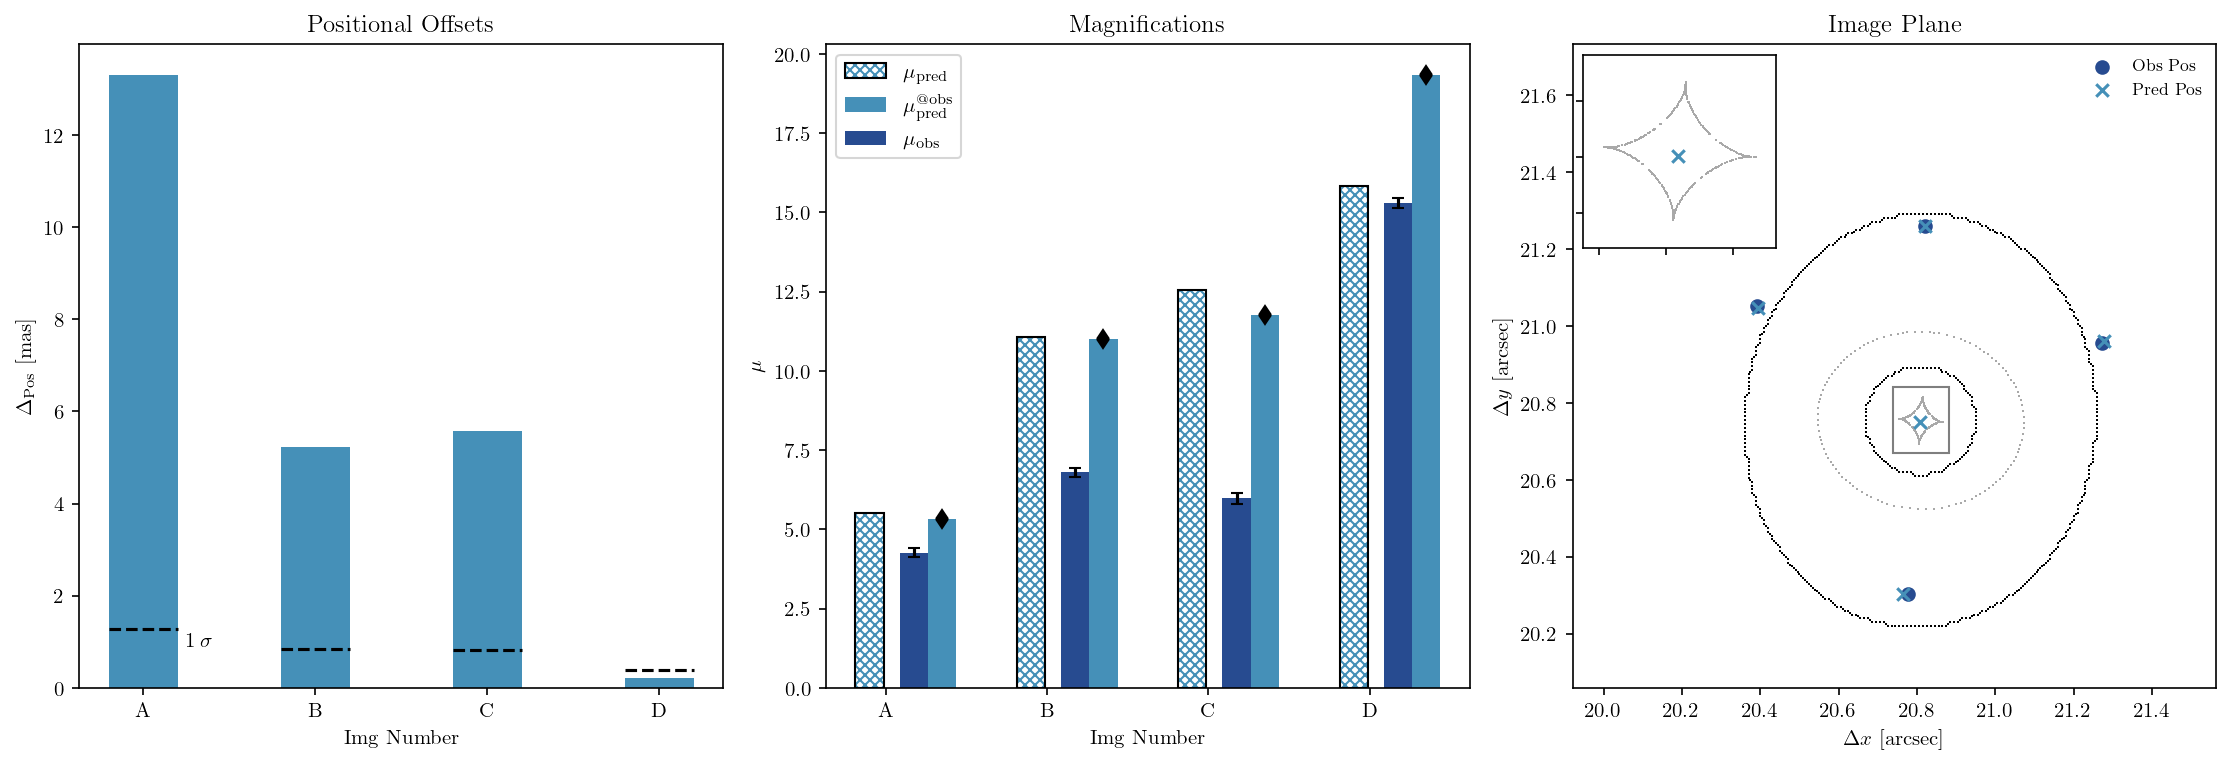

In [28]:
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(5*3,5),facecolor='white',dpi=150)
Plot_Image_Plane(LensImg_Obs,LensImg_Pred,source_pos,glafic_CritCurve_PATH)
plot_Magnifications(LensImg_Obs,LensImg_Pred,glafic_writelens_FITS_PATH)
plot_Pos_Offsets(LensImg_Obs,LensImg_Pred)

for i in range(len(axs)):
    axs[i].set_box_aspect(1) # Keep the plots in square shapes
fig.tight_layout()
plt.savefig('Images' + '/' + model_ver + '+Sersic' + '_image.png', bbox_inches='tight')
plt.show()